<a href="https://colab.research.google.com/github/danyentezari/bn-ocr/blob/main/keras_ocr_realvalues_bignumber_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.2.5
!pip install tensorflow==1.13.1
!unzip kaggle.json.zip
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download scolianni/mnistasjpg
!unzip mnistasjpg.zip
!pip install keras==2.2.5
!pip install tensorflow==1.13.1
!pip install 'h5py==2.10.0' --force-reinstall
!pip install cairocffi

In [12]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from scipy.sparse import csr_matrix
import cv2

from sklearn.feature_extraction.text import HashingVectorizer

import string
from PIL import Image
import numpy as np

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import itertools

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator

In [13]:
alphabet = '0123456789'
# def encode_to_labels(txt):
#     # encoding each output word into digits
#     dig_lst = []
#     for index, char in enumerate(txt):
#         if char in char_list:
#             dig_lst.append(char_list.index(char))
#         # else:
#         #   print(char)
#     return dig_lst

In [14]:
def labels_to_text(labels, alphabet):
    """Reverse translation of numerical classes back to characters."""
    ret = []
    for c in labels:
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    return "".join(ret)


def text_to_labels(text, alphabet):
    """ Translation of characters to unique integer values
    """
    ret = []
    for char in text:
        ret.append(alphabet.find(char))
    return ret


def decode_batch(test_func, word_batch, alphabet):
    """
    - Greedy search -
    For a real OCR application, this should be beam
    search with a dictionary and language model.
    For this example, best path is sufficient.
    """
    res = []
    prob = []
    out = test_func([word_batch])[0]
    for i in range(out.shape[0]):
        out_best = list(np.argmax(out[i, 2:], 1))
        out_prob = np.mean(np.max(out[i, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best, alphabet)
        res.append(outstr)
        prob.append(out_prob)
    return res, prob


In [15]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
# # # Get features
# !gdown https://drive.google.com/uc?id=176PKaCUDWmTJdQwc-OfkO0y8t4gLsIvQ
# !unzip formulae.zip

# # # Get labels
# !gdown https://drive.google.com/uc?id=1QUjX6PFWPa-HBWdcY-7bA5TRVUnbyS1D

In [17]:
# alphabet = string.digits + \
#            string.ascii_lowercase + \
#            string.ascii_uppercase + \
#            '\n' + \
#            '\t' + \
#            "".join([' ', '~', ':', "'", '+', '[', '\\', '@', '^', '{', '%', '(', '-', '"', '*', '|', ',', '&', '<', '`', '}', '.', '_', '=', ']', '!', '>', ';', '?', '#', '$', ')', '/'])

In [18]:
def loadImage(filepath):
  img = load_img(filepath)
  img = img_to_array(img)
  # img = img.reshape(1, 448, 64, 3)
  # img = img.reshape(64, 192, 3)
  img = img.astype('float32')
  img = img / 255.0
  return img

In [19]:
from os import listdir
from os.path import isfile, join

ch = 28
cw = 28

data_F = np.empty((0, ch, cw, 3))
data_L = np.empty((0))

i = 0
for f_label in listdir('./trainingSet/trainingSet'):
  for img_name in listdir(f'./trainingSet/trainingSet/{f_label}'):
    img = loadImage(f'./trainingSet/trainingSet/{f_label}/{img_name}')

    # if i == 1:
    #   break

    # print(np.array([img]).shape)
    # print(data_F.shape)
    # i = 1

    data_F = np.append(data_F, [img], axis=0)
    data_L = np.append(data_L, [f_label], axis=0)

In [20]:
data_L_dist = to_categorical(data_L)

In [21]:
sample_image = loadImage('./trainingSet/trainingSet/0/img_1.jpg')
Image.fromarray(np.uint8(sample_image*255)).convert('RGB')

### Features and Labels

In [22]:
print(data_F.shape)
print(data_L.shape)
print(data_L_dist.shape)

(42000, 28, 28, 3)
(42000,)
(42000, 10)


In [23]:
# train_L_id = np.array([np.zeros(max_word_length_track)])
# train_L_t = []

# for i,label in enumerate(train_L):
#   ids = np.zeros(max_word_length_track)
#   new_item = [float(alphabet_t2id[t]) for i,t in enumerate(list(label))]
#   ids[0: len(new_item)] = new_item
#   train_L_id = np.append(train_L_id, [ids], axis=0)


# # train_L_id = np.delete(train_L_id, [0])
# train_L_id = train_L_id[1:]
# len(train_L_id)

### Model

In [24]:
import os
import itertools
import codecs
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import tensorflow
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
#from keras.metrics import Metric
from tensorflow.python.keras.metrics import Metric

OUTPUT_DIR = 'image_ocr'


def NNModel():
  # Input Parameters
  img_w = cw
  img_h = ch
  words_per_epoch = 16000
  val_split = 0.2
  val_words = int(words_per_epoch * (val_split))

  # Network parameters
  conv_filters = 16
  kernel_size = (3, 3)
  pool_size = 2
  time_dense_size = 32
  rnn_size = 512
  minibatch_size = 32


  input_shape = (ch, cw, 3)

  act = 'relu'
  input_data = Input(name='the_input', shape=input_shape, dtype='float32')
  inner = Conv2D(conv_filters, kernel_size, padding='same',
                  activation=act, kernel_initializer='he_normal',
                  name='conv1')(input_data)
  inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
  inner = Conv2D(conv_filters, kernel_size, padding='same',
                  activation=act, kernel_initializer='he_normal',
                  name='conv2')(inner)
  inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

  conv_to_rnn_dims = (img_w // (pool_size ** 2),
                      (img_h // (pool_size ** 2)) * conv_filters)
  inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

  # cuts down input size going into RNN:
  inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

  # Two layers of bidirectional GRUs
  # GRU seems to work as well, if not better than LSTM:
  gru_1 = GRU(rnn_size, return_sequences=True,
              kernel_initializer='he_normal', name='gru1')(inner)
  gru_1b = GRU(rnn_size, return_sequences=True,
                go_backwards=True, kernel_initializer='he_normal',
                name='gru1_b')(inner)
  gru1_merged = add([gru_1, gru_1b])
  gru_2 = GRU(rnn_size, return_sequences=True,
              kernel_initializer='he_normal', name='gru2')(gru1_merged)
  gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,
                kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

  # transforms RNN output to character activations:
  inner = Dense(
      len(alphabet), 
      kernel_initializer='he_normal',
      name='dense2')(concatenate([gru_2, gru_2b])
    )
  y_pred = Activation('softmax', name='softmax')(inner)



  labels = Input(name='the_labels', shape=[1], dtype='float32')
  input_length = Input(name='input_length', shape=[1], dtype='int64')
  label_length = Input(name='label_length', shape=[1], dtype='int64')


  # model0 = Model(
  #     inputs=[input_data, labels, input_length, label_length],
  #     outputs=y_pred
  # )


  def ctc_lambda_func(args):
      y_pred, labels, input_length, label_length = args
      # the 2 is critical here since the first couple outputs of the RNN
      # tend to be garbage:
      y_pred = y_pred[:, 2:, :]
      return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

  # Keras doesn't currently support loss funcs with extra parameters
  # so CTC loss is implemented in a lambda layer
  loss_out = Lambda(
      ctc_lambda_func, output_shape=(1,),
      name='ctc')([y_pred, labels, input_length, label_length])

  # clipnorm seems to speeds up convergence
  sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

  model0 = Model(
          inputs=[input_data, labels, input_length, label_length],
          outputs=loss_out
      )

  model0.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')


  model0.summary()
  train_model = model0

  prediction_model = Model(inputs=input_data, outputs=y_pred)

  return train_model, prediction_model


model0, _ = NNModel()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 28, 16)   448         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 14, 14, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 14, 14, 16)   2320        max1[0][0]                       
____________________

In [ ]:
# batch_size = 25 #a divisor of training length
# epochs = 5

# input_length = np.array([ [10] for i in range(len(train_F)) ])
# label_length = np.array([ [10] for i in range(len(train_F)) ])

# metrics0 = model0.fit(
#           x=[
#               train_F, 
#               train_L_dist, 
#               input_length,
#               label_length,
#             ], 
#           # y = np.zeros(len(train_F)),
#           y = train_L_dist,
#           # batch_size=batch_size, 
#           epochs = epochs, 
#           # validation_data = ([val_img, val_padded_txt, val_input_length, val_label_length], val_padded_txt),
#           verbose = 2,
#           # callbacks = callbacks_list
# )

In [ ]:
# model0.save_weights( './weights1-mnist.h5' )

### Alternative Model

In [26]:
train_F, test_F, train_L_dist, test_L_dist = train_test_split(data_F, data_L_dist, test_size=0.1, random_state=0)

In [27]:
train_F.shape, test_F.shape, train_L_dist.shape, test_L_dist.shape

((37800, 28, 28, 3), (4200, 28, 28, 3), (37800, 10), (4200, 10))

In [28]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(train_F, train_L_dist, batch_size=128)
test_gen = datagen.flow(test_F, test_L_dist, batch_size=128)

In [29]:
epochs = 5
batch_size = 128
train_steps = train_F.shape[0] // batch_size
valid_steps = train_L_dist.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [30]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers.normalization import BatchNormalization

model1=Sequential()

#model1.add(Lambda(standardize,input_shape=(28,28,1)))    
model1.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,3)))
model1.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())

model1.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model1.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())    

model1.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())
    
model1.add(Flatten())
model1.add(Dense(512,activation="relu"))
    
model1.add(Dense(10,activation="softmax"))
    
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
# metrics1 = model1.fit(x=train_F, y=train_L_dist, epochs=20, verbose=1)

# Fit the model
metrics1 = model1.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
295/295 [==============================] - 710s 2s/step - loss: 0.1600 - acc: 0.9505 - val_loss: 0.1161 - val_acc: 0.9654
Epoch 2/5
295/295 [==============================] - 597s 2s/step - loss: 0.0625 - acc: 0.9808 - val_loss: 0.0540 - val_acc: 0.9839
Epoch 3/5
295/295 [==============================] - 561s 2s/step - loss: 0.0471 - acc: 0.9855 - val_loss: 0.0828 - val_acc: 0.9759
Epoch 4/5
295/295 [==============================] - 524s 2s/step - loss: 0.0450 - acc: 0.9862 - val_loss: 0.0768 - val_acc: 0.9788
Epoch 5/5
295/295 [==============================] - 532s 2s/step - loss: 0.0368 - acc: 0.9887 - val_loss: 0.0698 - val_acc: 0.9803

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


In [36]:
model1.save_weights( './weights2-mnist.h5' )

In [41]:
yhat = model1.predict(data_F[300].reshape(1, ch, cw, 3))
# np.argmax(yhat, axis=1).tolist()
yhat.argmax()

3

### Predict

In [32]:
metrics1

In [33]:
# pred = model0.predict(
#     [train_F, train_L_id, np.array([1]), np.array([1])]
# )

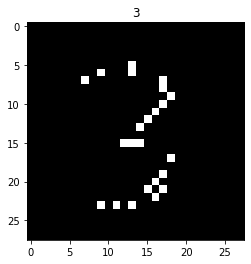

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
img = data_F[300]
img = img.astype(np.uint8) 
plt.title(data_L[300])
plt.imshow(img * 255)

In [ ]:
# !git clone https://github.com/danyentezari/model_weights.git

In [ ]:
_, model_infer = NNModel()
# model_infer.load_weights("./model_weights/weights0-mnist.h5")
model_infer.load_weights("./weights1-mnist.h5")


In [ ]:
# sample = train_F[0].reshape(1, 100, 780, 3)
yhat = model_infer.predict(train_F[9000].reshape(1, ch, cw, 3))

In [ ]:
np.argmax(yhat, axis=1).tolist()